In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import mutual_info_classif

df = pd.read_csv("adult_with_headers.csv")
df.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:

df.info()
df.describe(include='all')
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [3]:

df = df.dropna()
num_cols = df.select_dtypes(include=['int64','float64']).columns

df_std = df.copy()
df_std[num_cols] = StandardScaler().fit_transform(df_std[num_cols])

df_mm = df.copy()
df_mm[num_cols] = MinMaxScaler().fit_transform(df_mm[num_cols])


In [4]:

cat_cols = df.select_dtypes(include=['object']).columns
df_enc = df.copy()

for col in cat_cols:
    if df[col].nunique() < 5:
        df_enc = pd.get_dummies(df_enc, columns=[col], prefix=col)
    else:
        df_enc[col] = LabelEncoder().fit_transform(df[col])

df_enc.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,sex_ Female,sex_ Male,income_ <=50K,income_ >50K
0,39,7,77516,9,13,4,1,1,4,2174,0,40,39,False,True,True,False
1,50,6,83311,9,13,2,4,0,4,0,0,13,39,False,True,True,False
2,38,4,215646,11,9,0,6,1,4,0,0,40,39,False,True,True,False
3,53,4,234721,1,7,2,6,0,2,0,0,40,39,False,True,True,False
4,28,4,338409,9,13,2,10,5,2,0,0,40,5,True,False,True,False


In [5]:

df_fe = df_enc.copy()

df_fe['age_group'] = pd.cut(df_fe['age'], bins=[0,25,45,65,100],
                            labels=['young','adult','middle','senior'])

df_fe['capital_diff'] = df_fe['capital_gain'] - df_fe['capital_loss']
df_fe['log_hours'] = np.log1p(df_fe['hours_per_week'])

df_fe[['age_group','capital_diff','log_hours']].head()


,age_group,capital_diff,log_hours
0,adult,2174,3.713572
1,middle,0,2.639057
2,adult,0,3.713572
3,middle,0,3.713572
4,adult,0,3.713572


In [6]:

iso = IsolationForest(contamination=0.02, random_state=42)
mask = iso.fit_predict(df_fe.select_dtypes(include=[np.number]))
df_no_outliers = df_fe[mask == 1]
df_no_outliers.shape


(31909, 20)

In [7]:

df_mi = df_no_outliers.copy()

# Encode age_group
if str(df_mi['age_group'].dtype) == 'category':
    df_mi['age_group'] = df_mi['age_group'].cat.codes
else:
    df_mi['age_group'] = df_mi['age_group'].map({'young':0,'adult':1,'middle':2,'senior':3})

# Convert boolean columns
bool_cols = df_mi.select_dtypes(include=['bool']).columns
df_mi[bool_cols] = df_mi[bool_cols].astype(int)

target = 'income_ >50K'
X = df_mi.drop(target, axis=1)
y = df_mi[target]

mi = mutual_info_classif(X, y, discrete_features='auto')
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
mi_scores.head(20)


income_ <=50K     0.551024
relationship      0.116609
marital_status    0.108602
capital_diff      0.107571
capital_gain      0.071419
age               0.069324
education         0.063158
occupation        0.062787
education_num     0.060814
age_group         0.052238
hours_per_week    0.042380
log_hours         0.040639
capital_loss      0.034563
sex_ Male         0.032245
fnlwgt            0.031329
sex_ Female       0.028459
workclass         0.013981
race              0.012290
native_country    0.011126
dtype: float64

In [8]:

df_corr = df_mi.copy()


df_corr = df_corr.select_dtypes(include=[int, float])

spearman_corr = df_corr.corr(method='spearman')
spearman_corr


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,sex_ Female,sex_ Male,income_ <=50K,income_ >50K,capital_diff,log_hours
age,1.000000,0.058542,-0.078023,-0.024732,0.065781,-0.382574,-0.003327,-0.326924,0.032919,0.110640,0.053384,0.150640,0.015843,-0.103821,0.103821,-0.270885,0.270885,0.054865,0.150640
workclass,0.058542,1.000000,-0.029299,0.004142,0.031449,-0.069469,0.196089,-0.114736,0.061440,0.020825,0.009692,0.127099,-0.007124,-0.110829,0.110829,-0.055431,0.055431,0.010548,0.127099
fnlwgt,-0.078023,-0.029299,1.000000,-0.020972,-0.034789,0.034829,0.000572,0.012945,-0.040861,-0.004536,-0.007336,-0.022058,-0.082366,-0.025562,0.025562,0.009084,-0.009084,0.000767,-0.022058
education,-0.024732,0.004142,-0.020972,1.000000,0.198128,-0.010090,-0.038007,0.020517,0.003801,0.000146,0.011462,0.004821,0.077275,0.039122,-0.039122,-0.024224,0.024224,-0.006564,0.004821
education_num,0.065781,0.031449,-0.034789,0.198128,1.000000,-0.058345,0.111351,-0.092004,0.044742,0.099027,0.074896,0.161022,0.051368,-0.000036,0.000036,-0.319862,0.319862,0.033399,0.161022
marital_status,-0.382574,-0.069469,0.034829,-0.010090,-0.058345,1.000000,-0.010243,0.318443,-0.087887,-0.070726,-0.043505,-0.213468,-0.033343,0.154107,-0.154107,0.235768,-0.235768,-0.029627,-0.213468
occupation,-0.003327,0.196089,0.000572,-0.038007,0.111351,-0.010243,1.000000,-0.074260,0.007543,0.018338,0.017668,0.083866,-0.008213,-0.076983,0.076983,-0.078692,0.078692,0.003985,0.083866
relationship,-0.326924,-0.114736,0.012945,0.020517,-0.092004,0.318443,-0.074260,1.000000,-0.133113,-0.098567,-0.073083,-0.303262,-0.005230,0.615643,-0.615643,0.333113,-0.333113,-0.033996,-0.303262
race,0.032919,0.061440,-0.040861,0.003801,0.044742,-0.087887,0.007543,-0.133113,1.000000,0.037178,0.034587,0.075049,0.159180,-0.099731,0.099731,-0.086017,0.086017,0.008722,0.075049
capital_gain,0.110640,0.020825,-0.004536,0.000146,0.099027,-0.070726,0.018338,-0.098567,0.037178,1.000000,-0.060895,0.081345,0.033668,-0.062728,0.062728,-0.244267,0.244267,0.812795,0.081345


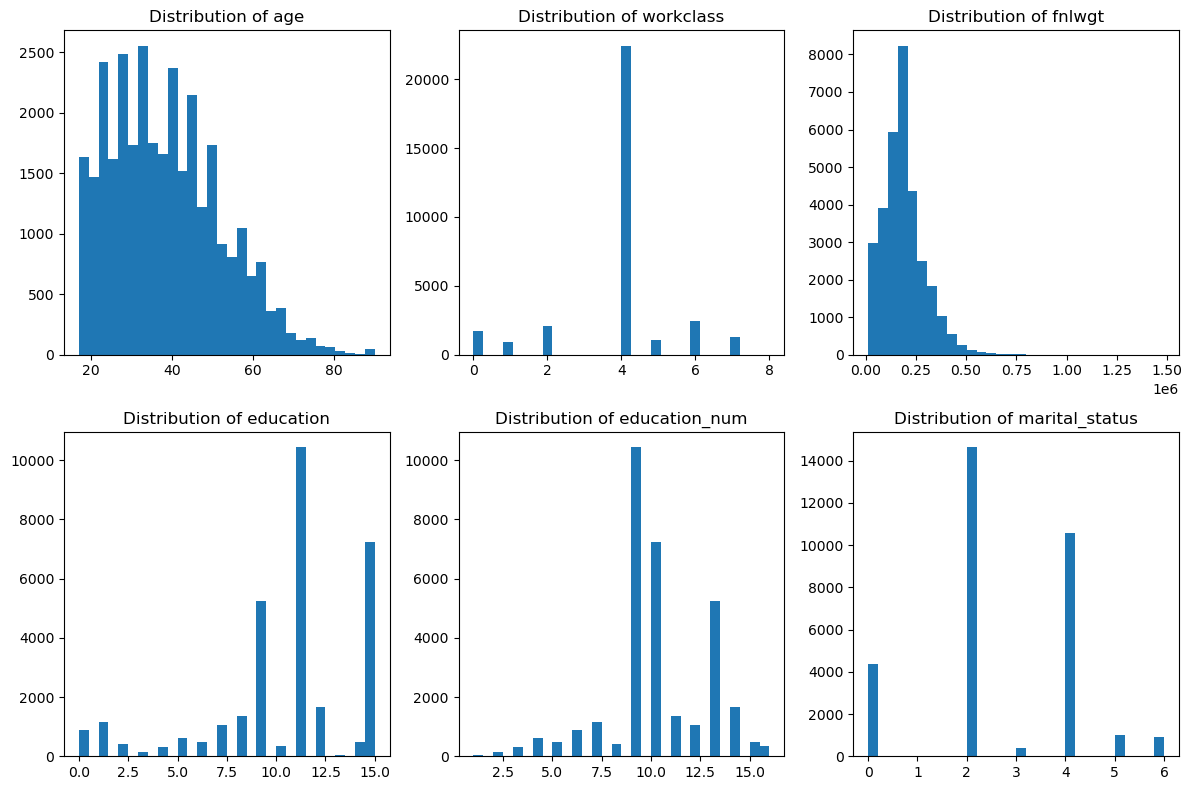

In [9]:
import matplotlib.pyplot as plt

num_cols = df_no_outliers.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols[:6]):  
    plt.subplot(2,3,i+1)
    plt.hist(df_no_outliers[col], bins=30)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


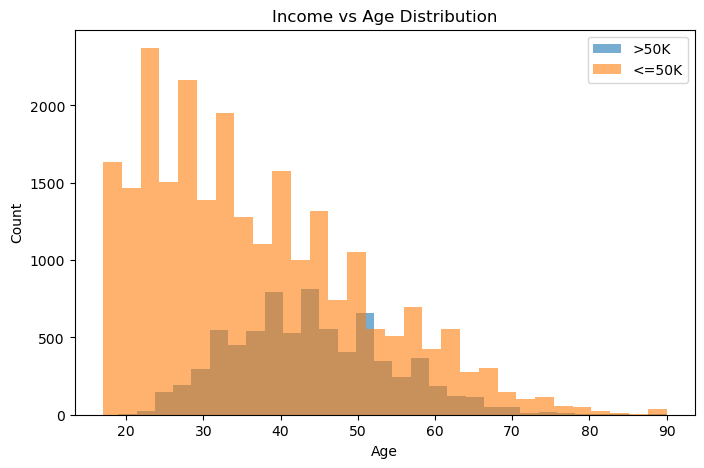

In [10]:
plt.figure(figsize=(8,5))
plt.hist(df_no_outliers[df_no_outliers['income_ >50K']==1]['age'], 
         bins=30, alpha=0.6, label=">50K")
plt.hist(df_no_outliers[df_no_outliers['income_ >50K']==0]['age'], 
         bins=30, alpha=0.6, label="<=50K")
plt.legend()
plt.title("Income vs Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


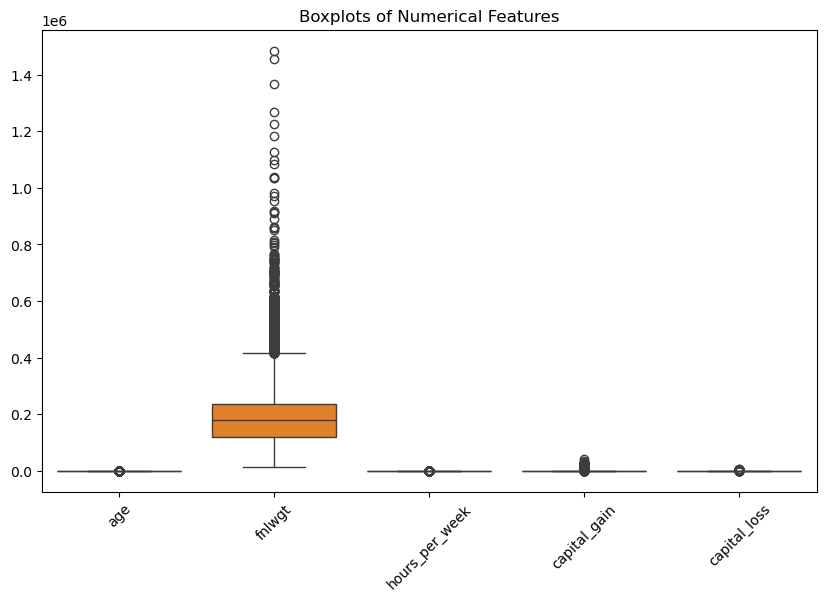

In [11]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.boxplot(data=df_no_outliers[['age','fnlwgt','hours_per_week','capital_gain','capital_loss']])
plt.xticks(rotation=45)
plt.title("Boxplots of Numerical Features")
plt.show()


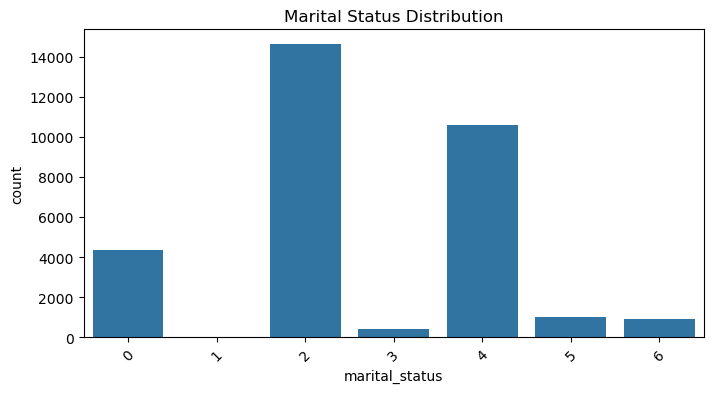

In [12]:
plt.figure(figsize=(8,4))
sns.countplot(x='marital_status', data=df_no_outliers)
plt.xticks(rotation=45)
plt.title("Marital Status Distribution")
plt.show()


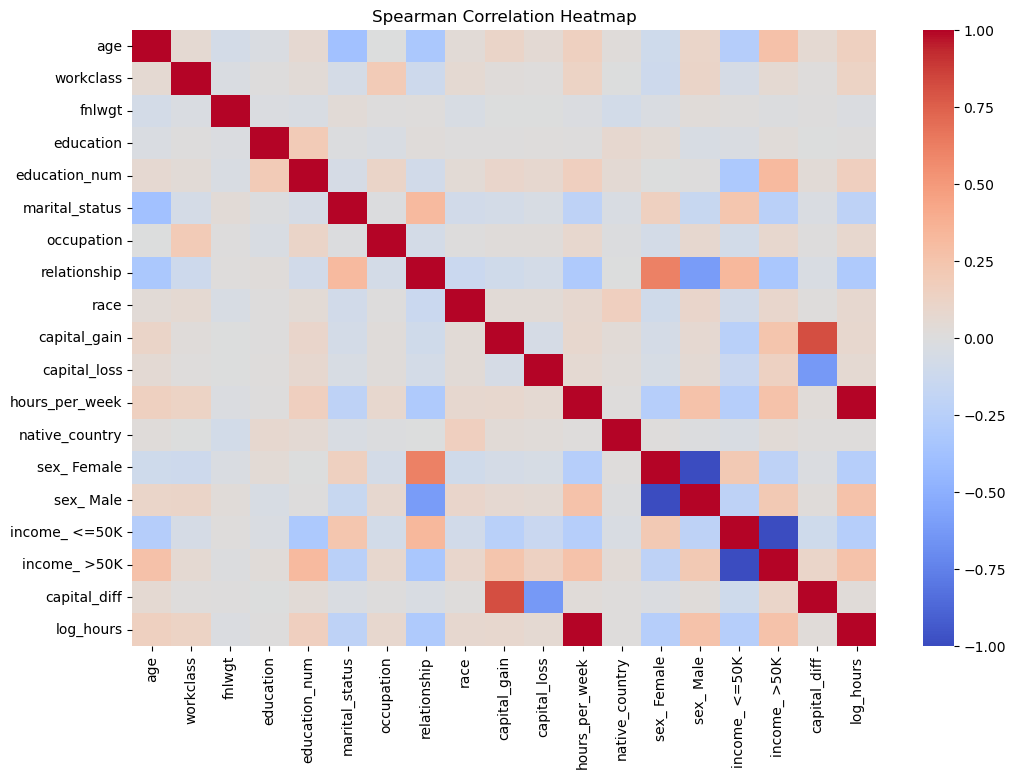

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(spearman_corr, cmap='coolwarm', annot=False)
plt.title("Spearman Correlation Heatmap")
plt.show()


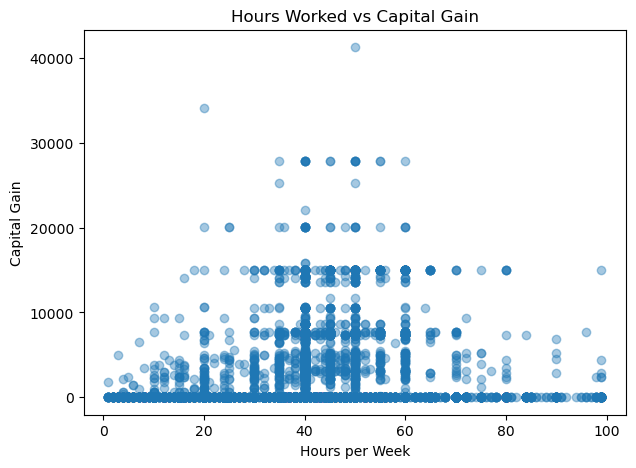

In [14]:
plt.figure(figsize=(7,5))
plt.scatter(df_no_outliers['hours_per_week'], df_no_outliers['capital_gain'], alpha=0.4)
plt.xlabel('Hours per Week')
plt.ylabel('Capital Gain')
plt.title('Hours Worked vs Capital Gain')
plt.show()


C:\Users\harsh\AppData\Local\Temp\ipykernel_13100\4000969009.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_no_outliers.groupby('age_group')['hours_per_week'].mean().plot(kind='bar')


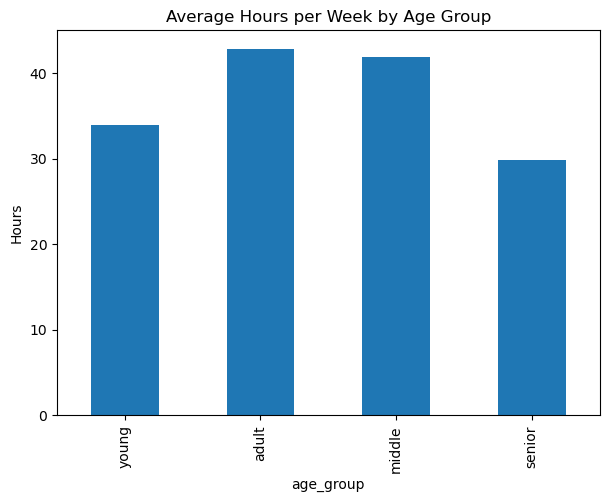

In [15]:
plt.figure(figsize=(7,5))
df_no_outliers.groupby('age_group')['hours_per_week'].mean().plot(kind='bar')
plt.title("Average Hours per Week by Age Group")
plt.ylabel("Hours")
plt.show()


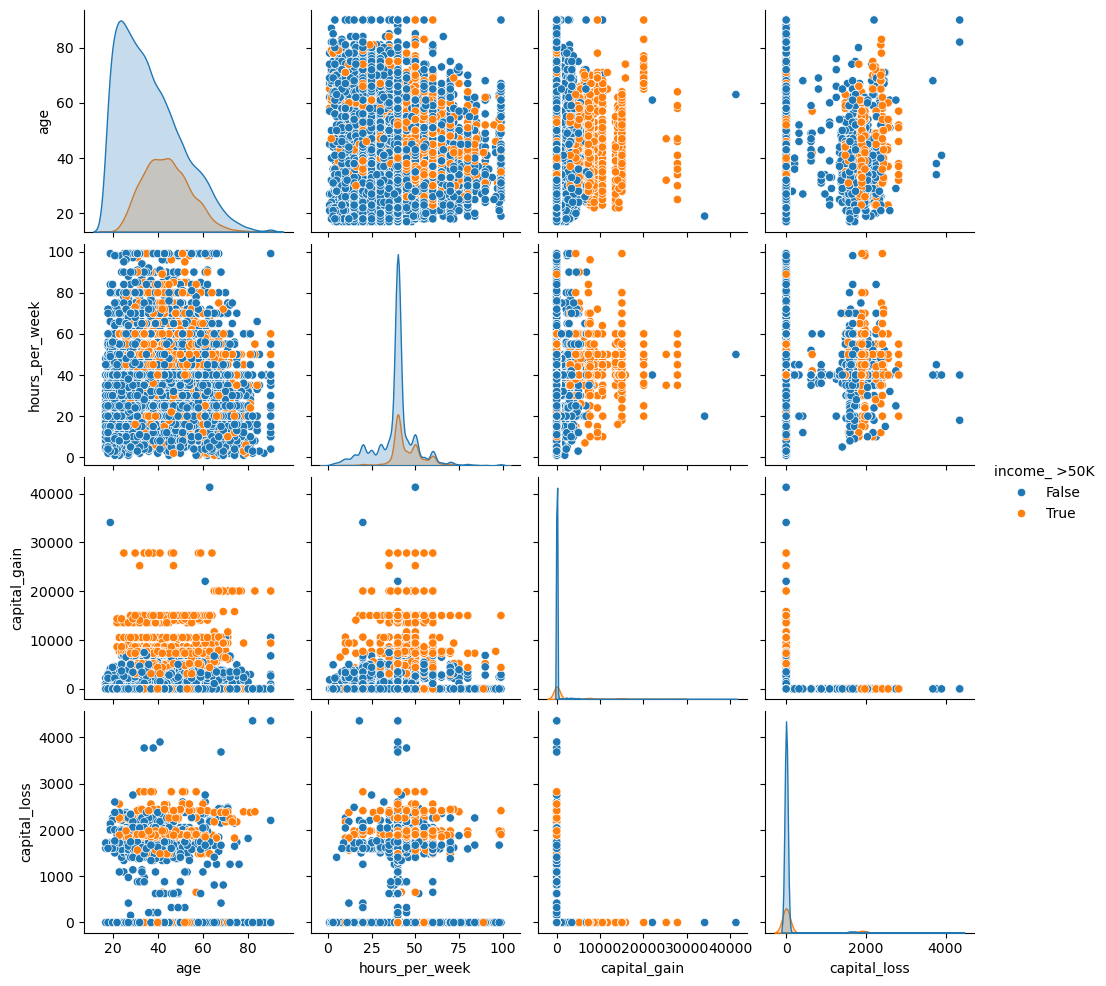

In [16]:
sns.pairplot(df_no_outliers[['age','hours_per_week','capital_gain','capital_loss','income_ >50K']],
             hue='income_ >50K')
plt.show()
